# [파이프라인 구축]

## 데이터 입력 및 전처리

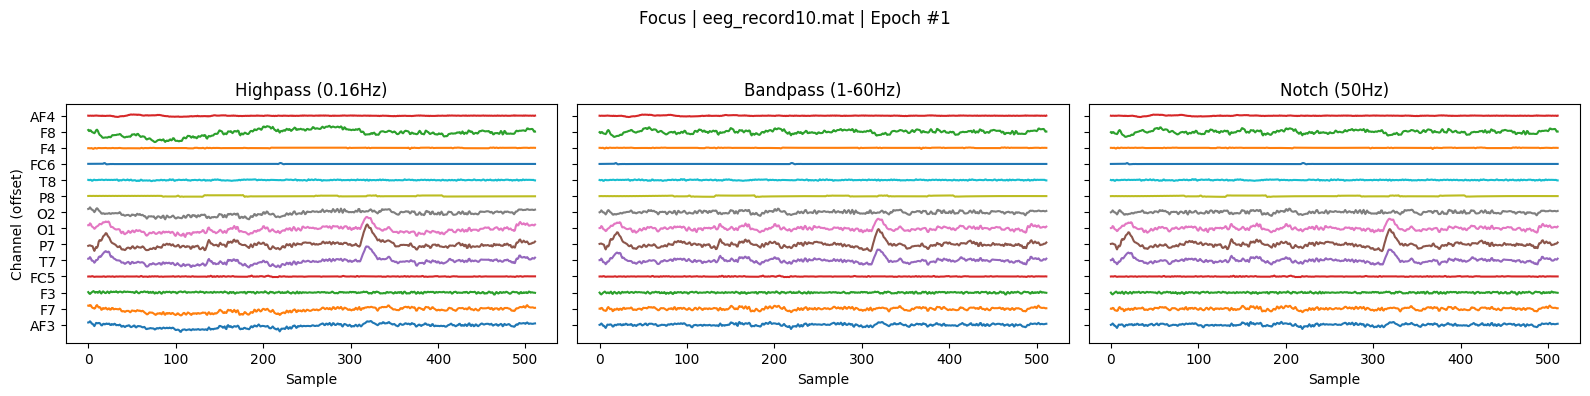

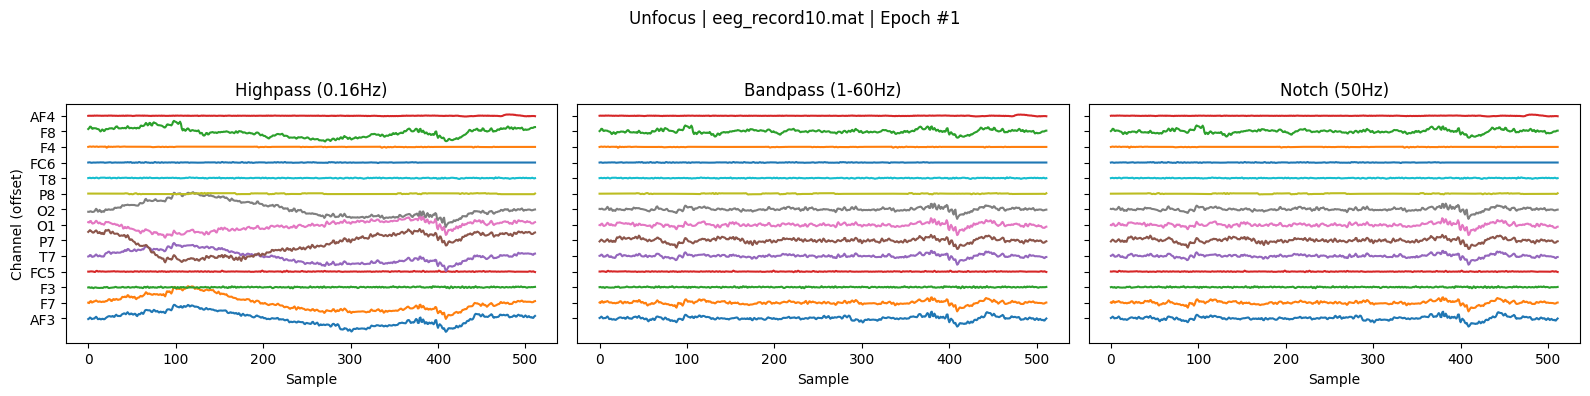

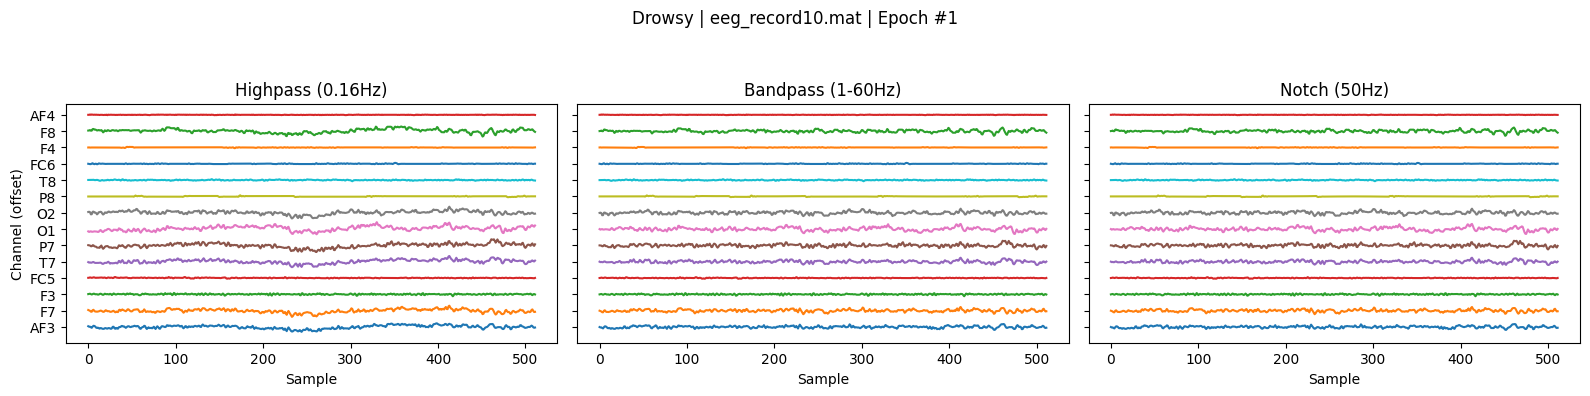

Focus epochs shape:   (9867, 512, 14)
Unfocus epochs shape: (9867, 512, 14)
Drowsy epochs shape:  (9805, 512, 14)


In [ ]:
import os
import numpy as np
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch
import matplotlib.pyplot as plt

data_dir = '_EEG Data'
mat_files = [
    os.path.join(data_dir, f)
    for f in os.listdir(data_dir)
    if f.endswith('.mat') and f != 'eeg_record1.mat'
]

eeg_idx = list(range(4, 18))
channel_names = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
    'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'
]
state_names = ['Focus', 'Unfocus', 'Drowsy']
segment_duration_min = 10

n_examples = 1
plot_sampled = {state: 0 for state in state_names}
offset = 100

def highpass_filter(data, fs, cutoff=0.16, order=1):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff/nyq, btype='high')
    return filtfilt(b, a, data, axis=0)

def bandpass_filter(data, fs, lowcut=1, highcut=60, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut/nyq, highcut/nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter_func(data, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

def make_epochs(data, fs, epoch_sec=4, step_sec=2):
    epoch_len = int(epoch_sec * fs)
    step_len = int(step_sec * fs)
    epochs = []
    for start in range(0, data.shape[0] - epoch_len + 1, step_len):
        epochs.append(data[start:start + epoch_len, :])
    return np.stack(epochs, axis=0) if len(epochs) > 0 else None

epochs_dict = {state: [] for state in state_names}

for mat_path in mat_files:

    mat = scipy.io.loadmat(mat_path)
    o = mat['o'][0,0]
    data = o['data']
    fs = int(o['sampFreq'][0,0])
    marker = int(fs * 60 * segment_duration_min)
    x = data[:, eeg_idx]

    segments = {
        'Focus': x[0:marker, :],
        'Unfocus': x[marker:2*marker, :],
        'Drowsy': x[2*marker:3*marker, :]
    }

    for state in state_names:
        seg = segments[state]

        x_hp = highpass_filter(seg, fs, cutoff=0.16)
        x_bp = bandpass_filter(x_hp, fs, 1, 60)
        x_nt = notch_filter_func(x_bp, fs, 50)

        epochs = make_epochs(x_nt, fs, epoch_sec=4, step_sec=2)

        if epochs is not None and plot_sampled[state] < n_examples:
            for i in range(min(n_examples - plot_sampled[state], len(epochs))):
                ep_hp = x_hp[i*fs*2 : i*fs*2 + fs*4]
                ep_bp = x_bp[i*fs*2 : i*fs*2 + fs*4]
                ep_nt = x_nt[i*fs*2 : i*fs*2 + fs*4]
                fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
                for ch in range(ep_hp.shape[1]):
                    axs[0].plot(ep_hp[:, ch] + ch*offset)
                axs[0].set_title('Highpass (0.16Hz)')
                axs[0].set_yticks([i*offset for i in range(len(channel_names))])
                axs[0].set_yticklabels(channel_names)
                axs[0].set_xlabel('Sample')
                axs[0].set_ylabel('Channel (offset)')
                for ch in range(ep_bp.shape[1]):
                    axs[1].plot(ep_bp[:, ch] + ch*offset)
                axs[1].set_title('Bandpass (1-60Hz)')
                axs[1].set_yticks([i*offset for i in range(len(channel_names))])
                axs[1].set_yticklabels(channel_names)
                axs[1].set_xlabel('Sample')
                for ch in range(ep_nt.shape[1]):
                    axs[2].plot(ep_nt[:, ch] + ch*offset)
                axs[2].set_title('Notch (50Hz)')
                axs[2].set_yticks([i*offset for i in range(len(channel_names))])
                axs[2].set_yticklabels(channel_names)
                axs[2].set_xlabel('Sample')
                plt.suptitle(f'{state} | {os.path.basename(mat_path)} | Epoch #{plot_sampled[state]+1}')
                plt.tight_layout(rect=[0, 0, 1, 0.92])
                plt.show()
                plot_sampled[state] += 1
                if plot_sampled[state] >= n_examples:
                    break

        if epochs is not None:
            epochs_dict[state].append(epochs)

epochs_focus   = np.concatenate(epochs_dict['Focus'],   axis=0)
epochs_unfocus = np.concatenate(epochs_dict['Unfocus'], axis=0)
epochs_drowsy  = np.concatenate(epochs_dict['Drowsy'],  axis=0)

print(f"Focus epochs shape:   {epochs_focus.shape}")    # (n_epochs, epoch_len, n_channels)
print(f"Unfocus epochs shape: {epochs_unfocus.shape}")
print(f"Drowsy epochs shape:  {epochs_drowsy.shape}")


In [25]:
np.save('epochs_focus.npy',   epochs_focus)
np.save('epochs_unfocus.npy', epochs_unfocus)
np.save('epochs_drowsy.npy',  epochs_drowsy)

## 특징 추출

In [ ]:
import numpy as np
from mne.decoding import CSP
from joblib import dump


X_all = np.concatenate([epochs_focus, epochs_unfocus, epochs_drowsy], axis=0)  # (n_epochs, 512, 14)
y_all = np.concatenate([
    np.zeros(len(epochs_focus), dtype=int),       # Focus: 0
    np.ones(len(epochs_unfocus), dtype=int),      # Unfocus: 1
    np.full(len(epochs_drowsy), 2, dtype=int)     # Drowsy: 2
])

n_csp = 6
feature_list = []
csp_models = {}

for target_class in [0, 1, 2]:
    y_bin = (y_all == target_class).astype(int)
    csp = CSP(n_components=n_csp, reg=None, log=True, norm_trace=False)
    X_csp = csp.fit_transform(X_all.transpose(0, 2, 1), y_bin)  # (n_epochs, 6)
    
    feature_list.append(X_csp)
    csp_models[target_class] = csp

    if target_class == 0:
        dump(csp, 'csp_focus_vs_rest.pkl')
    elif target_class == 1:
        dump(csp, 'csp_unfocus_vs_rest.pkl')
    else:
        dump(csp, 'csp_drowsy_vs_rest.pkl')

X_csp_ovr = np.concatenate(feature_list, axis=1)  # (n_epochs, 18)

np.save('feature_csp.npy', X_csp_ovr)
np.save('label_csp.npy', y_all)

print("최종 CSP(OvR) 특징 shape:", X_csp_ovr.shape)
print("라벨 shape:", y_all.shape)


Computing rank from data with rank=None
    Using tolerance 2.6e+02 (2.2e-16 eps * 14 dim * 8.5e+16  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 2.5e+02 (2.2e-16 eps * 14 dim * 7.9e+16  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e+02 (2.2e-16 eps * 14 dim * 9.9e+16  max singular value)
    Estimated rank (mag): 14
    MAG: rank 14 computed from 14 data channels with 0 projectors
Reducing data rank from 14 -> 14
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 1.7e+02 (2.2e-16 eps * 14 dim * 5.4e+16  max singular value)


In [27]:
np.save('feature_csp.npy',  X_csp_ovr)
np.save('label_csp.npy', y_all)

## 분류 모델 선정

In [28]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
     X_csp_ovr, y_all, test_size=0.2, random_state=42, stratify=y_all
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)


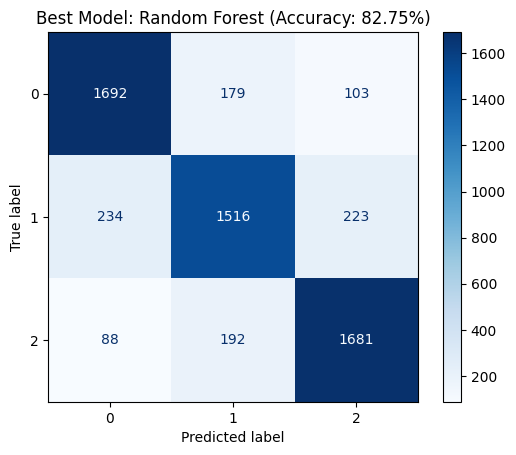

{'SVM (linear)': 0.580568720379147,
 'SVM (rbf)': 0.754739336492891,
 'LDA': 0.5766756939742722,
 'LogReg (L2)': 0.5753215978334462,
 'Random Forest': 0.8275220040622884,
 'Gradient Boosting': 0.6990521327014217,
 'KNN (k=5)': 0.8155044008124577,
 'Naive Bayes': 0.45649966147596477,
 'Ridge Classifier': 0.5673662830060935}

In [ ]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

models = {
    'SVM (linear)': SVC(kernel='linear', random_state=42),
    'SVM (rbf)': SVC(kernel='rbf', random_state=42),
    'LDA': LDA(),
    'LogReg (L2)': LogisticRegression(penalty='l2', max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Ridge Classifier': RidgeClassifier()
}

acc_dict = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)
    acc = accuracy_score(y_test, y_pred)
    acc_dict[name] = acc
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

best_model_name = max(acc_dict, key=acc_dict.get)
best_conf_matrix = conf_matrices[best_model_name]
best_acc = acc_dict[best_model_name]

disp = ConfusionMatrixDisplay(confusion_matrix=best_conf_matrix)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Best Model: {best_model_name} (Accuracy: {best_acc:.2%})')
plt.show()

acc_dict


## 최종 모델

In [30]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_csp_ovr = np.load('feature_csp.npy')
y_all = np.load('label_csp.npy')

X_train, X_test, y_train, y_test = train_test_split(
     X_csp_ovr, y_all, test_size=0.2, random_state=42, stratify=y_all
)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Train Accuracy: 0.8817
Test Accuracy:  0.8155


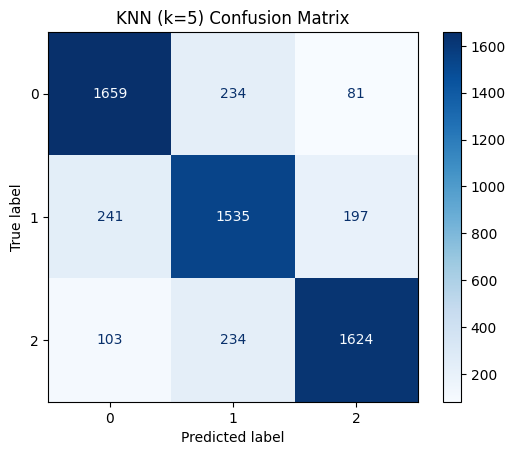

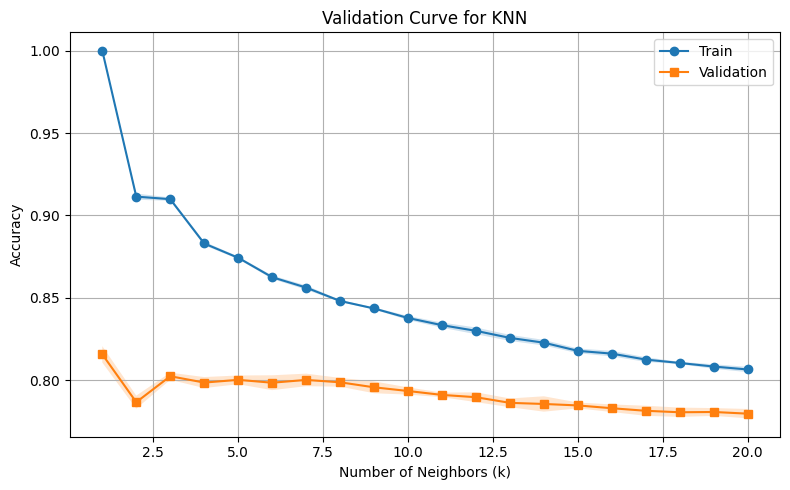

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, validation_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_std, y_train)

y_train_pred = knn.predict(X_train_std)
y_test_pred = knn.predict(X_test_std)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:  {test_acc:.4f}")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("KNN (k=5) Confusion Matrix")
plt.show()

k_range = range(1, 21)
train_scores, test_scores = validation_curve(
    KNeighborsClassifier(),
    X_train_std, y_train,
    param_name='n_neighbors',
    param_range=k_range,
    cv=5,
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(k_range, train_mean, label="Train", marker='o')
plt.fill_between(k_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(k_range, test_mean, label="Validation", marker='s')
plt.fill_between(k_range, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("Validation Curve for KNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
from joblib import dump

dump(knn, 'knn_model.joblib')
dump(scaler, 'scaler.joblib')

['scaler.joblib']

# [집중력 예측 데모]

데이터셋: 35-55분간 측파. 정된 뇌10분씩 분할하여 집중, 비집중, 졸림 상태.
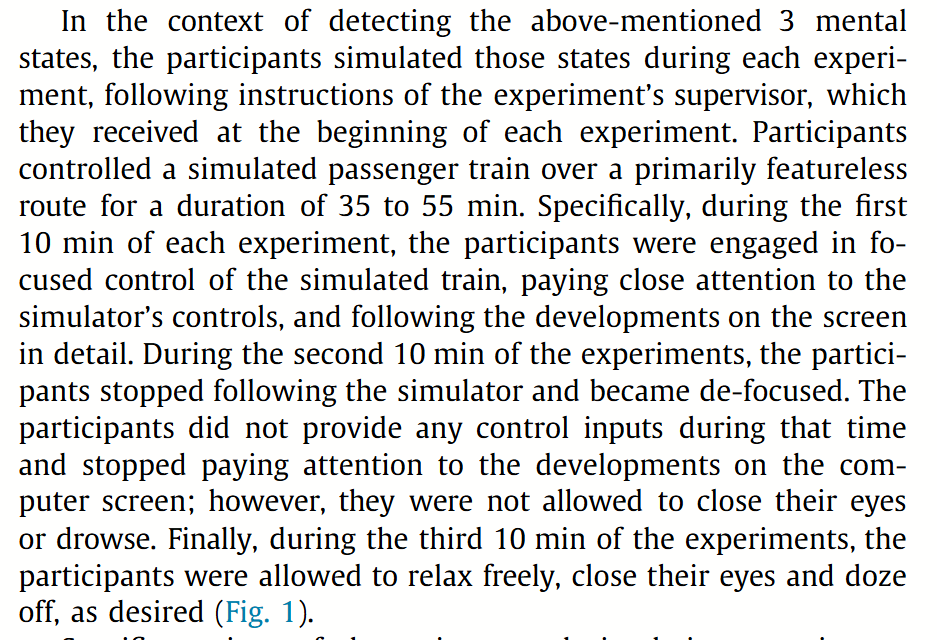

In [ ]:
import numpy as np
import pandas as pd
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch
from joblib import load
from mne.decoding import CSP
from collections import Counter

mat_path = 'EEG Data/eeg_record30.mat'
fs = 128
epoch_sec = 4
step_sec = 4
channel_idx = np.arange(4, 18)

def highpass_filter(data, fs, cutoff=0.16, order=1):
    nyq = 0.5 * fs
    b, a = butter(order, cutoff / nyq, btype='high')
    return filtfilt(b, a, data, axis=0)

def bandpass_filter(data, fs, lowcut=1, highcut=60, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data, axis=0)

def notch_filter(data, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, data, axis=0)

def make_epochs(data, fs, epoch_sec=4, step_sec=4):
    epoch_len = int(epoch_sec * fs)
    step_len = int(step_sec * fs)
    epochs = []
    for start in range(0, data.shape[0] - epoch_len + 1, step_len):
        epochs.append(data[start:start + epoch_len, :])
    return np.stack(epochs, axis=0)

# ------ 1. 데이터 입력 ------
mat = scipy.io.loadmat(mat_path)
raw = mat['o'][0, 0]['data']
eeg_data = raw[:, channel_idx]

# ------ 2. 전처리 ------
x = highpass_filter(eeg_data, fs)
x = bandpass_filter(x, fs)
x = notch_filter(x, fs)

# ------ 3. 구조화 ------
epochs = make_epochs(x, fs, epoch_sec=epoch_sec, step_sec=step_sec)  # shape: (n_epochs, time, channels)
X_epoch = epochs.transpose(0, 2, 1)

# ------4. 특징 추출 ------
csp_focus   = load('csp_focus_vs_rest.pkl')
csp_unfocus = load('csp_unfocus_vs_rest.pkl')
csp_drowsy  = load('csp_drowsy_vs_rest.pkl')

feat_focus   = csp_focus.transform(X_epoch)
feat_unfocus = csp_unfocus.transform(X_epoch)
feat_drowsy  = csp_drowsy.transform(X_epoch)

X_csp_ovr = np.concatenate([feat_focus, feat_unfocus, feat_drowsy], axis=1)

# ------ 5. 분류 ------
scaler = load('scaler.joblib')
knn_model = load('knn_model.joblib')
X_test_std = scaler.transform(X_csp_ovr)
y_pred = knn_model.predict(X_test_std)

# ------ 6. 예측 및 파일 저장 ------
label_map = {0: "집중", 1: "비집중", 2: "졸림"}
epochs_per_min = 60 // step_sec

summary_time = []
summary_pred = []

for i in range(0, len(y_pred), epochs_per_min):
    window = y_pred[i:i + epochs_per_min]
    if len(window) == 0:
        continue

    most_common = Counter(window).most_common(1)[0][0]
    minute = i // epochs_per_min
    time_str = f"{minute:02}:00"
    
    summary_time.append(time_str)
    summary_pred.append(label_map[most_common])

df_summary = pd.DataFrame({
    '시간': summary_time,
    '상태': summary_pred
})

df_summary.to_excel('시간별 집중도 변화.xlsx', index=False)
print("파일 저장 완료")

df_summary


파일 저장 완료


,시간,상태
0,00:00,집중
1,01:00,집중
2,02:00,집중
3,03:00,집중
4,04:00,집중
5,05:00,집중
6,06:00,집중
7,07:00,집중
8,08:00,집중
9,09:00,집중
